## Observation Error Demonstration
This notebook will show a simple example to show the incorporation of
observation error, and the effect of the associated parameter that
scales the observation error.

This notebook continues with the example in the linear_response_example.ipynb
notebook; a simple linear model makes validating the result simple.

Read in observations and modeling functions. The main function here
facilitates setting and fixing various model parameters. In this case,
fixing the parameters that correspond to a linear emulator response.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sepia import SepiaData, SepiaModel, SepiaPlot, \
    SepiaEmulatorPrediction, SepiaFullPrediction

def run_model(m=4, fix_lamOs=None, use_Sigy=None):
    t_sim=np.linspace(1,4,m).reshape((-1,1))
    y_sim=np.linspace(4,1,m).reshape((-1,1))
    y_obs=np.ones((1,1))*2.5

    # Use the observation error if supplied
    if not use_Sigy:
        dat = SepiaData(t_sim=t_sim, y_sim=y_sim, y_obs=y_obs)
    else:
        dat = SepiaData(t_sim=t_sim, y_sim=y_sim, y_obs=y_obs, Sigy=use_Sigy)

    dat.standardize_y()
    dat.transform_xt()

    mod=SepiaModel(dat)

    # Change default sepia model parameter based
    # on flags/values passed in.
    if fix_lamOs:
        # Scaling of observation error
        mod.params.lamOs.fixed[0,0]=True
        mod.params.lamOs.val[0,0]=fix_lamOs
        mod.params.lamOs.prior.bounds[0] = fix_lamOs / 2
        mod.params.lamOs.prior.bounds[1] = fix_lamOs * 2

    #fix other parameters to allow a highly-certain linear response emulator
    # Process precision - so it's not forcing N(0,1) marginal response locally
    mod.params.lamUz.fixed[0,0]=True
    mod.params.lamUz.val[0,0]=0.01
    mod.params.lamUz.prior.bounds=[np.array([[0]]),np.array([[1]]) ]
    # Nugget / noise process variance for simulations = near-zero variance
    mod.params.lamWs.fixed[0,0]=True
    mod.params.lamWs.val[0,0]=1e6
    mod.params.lamWs.prior.bounds=[np.array([[0]]),np.array([[1e8]]) ]
    # Scaling of simulator error = near-zero variance
    # (which is relevant to allocating relative uncertainty for multivariate response)
    mod.params.lamWOs.fixed[0,0]=True
    mod.params.lamWOs.val[0,0]=1e6
    mod.params.lamWOs.prior.bounds=[np.array([[0]]),np.array([[1e8]]) ]

    # "fit" the model by generating posterior samples
    mod.do_mcmc(100)  # go past transient
    mod.clear_samples()
    mod.do_mcmc(5000) # collect samples

    return mod

And some plotting routines

In [2]:
def plot_trace(mod):
    #call the trace plot built-in with the samples
    samp=mod.get_samples()
    SepiaPlot.mcmc_trace(samp)
    plt.show()

def plot_cal(mod):
    # plot the calibration setup and results
    psamp=mod.get_samples(numsamples=500)
    t_pred=np.linspace(0,5,50).reshape((-1,1))
    spred=SepiaEmulatorPrediction(t_pred=t_pred, model=mod, samples=psamp)
    ysp=spred.get_y()
    yspm=np.mean(ysp,axis=0).squeeze()
    ysps=np.std(ysp,axis=0).squeeze()

    opred=SepiaFullPrediction(model=mod,samples=psamp)
    yop=opred.get_yobs()

    fig,ax1 = plt.subplots()
    ax1.plot(t_pred,yspm,'k')
    ax1.plot(t_pred,yspm+2*ysps,'k.')
    ax1.plot(t_pred,yspm-2*ysps,'k.')
    ax1.plot(mod.data.sim_data.t,mod.data.sim_data.y,'go')
    ax1.plot(psamp['theta_native'],yop.squeeze(),'r.')
    calx=np.array([0,5]).reshape((-1,1))
    ax1.plot(calx,np.ones((2,1))*mod.data.obs_data.y,'b')
    ax1.plot(calx,np.ones((2,1))*(mod.data.obs_data.y+2*np.sqrt(mod.data.obs_data.Sigy)),'b:')
    ax1.plot(calx,np.ones((2,1))*(mod.data.obs_data.y-2*np.sqrt(mod.data.obs_data.Sigy)),'b:')
    ax2=ax1.twinx()
    sns.histplot(psamp['theta_native'],kde=True,color='r',ax=ax2,legend=False)
    ax2.set_ylabel(''); ax2.set_yticks([]); ax2.set_ybound([i*5 for i in ax2.get_ybound()])
    plt.show()

    samp=mod.get_samples()
    theta_std=np.std(samp['theta_native'],ddof=1)
    print('Theta std = %f, var = %f'%(theta_std,theta_std**2))


See the linearResponseExample for more detail on the settings.

Sepia handles emulation of multivariate responses, but we will not
show that in this example. The Al_5083_calibration example python file
and notebook shows a more full model.

The observation error is a covariance matrix, Sigy. Often Sigy will
only have entries on this diagonal of this covariance matrix, indicating
errors are considered independent. In this simple illustrative example
there is a scalar response, so Sigy is a scalar value.

Generate a model with an observation error of N(0,0.1), and calibrate the
parameter:

In [3]:
mod=run_model(fix_lamOs=1, use_Sigy=0.1)

MCMC sampling: 100%|██████████| 5000/5000 [00:06<00:00, 826.97it/s]


"Trace plot" shows model parameter samples. This is not very exciting, since the
many of the model parameters were set to a fixed value to make this
example's function very clear.

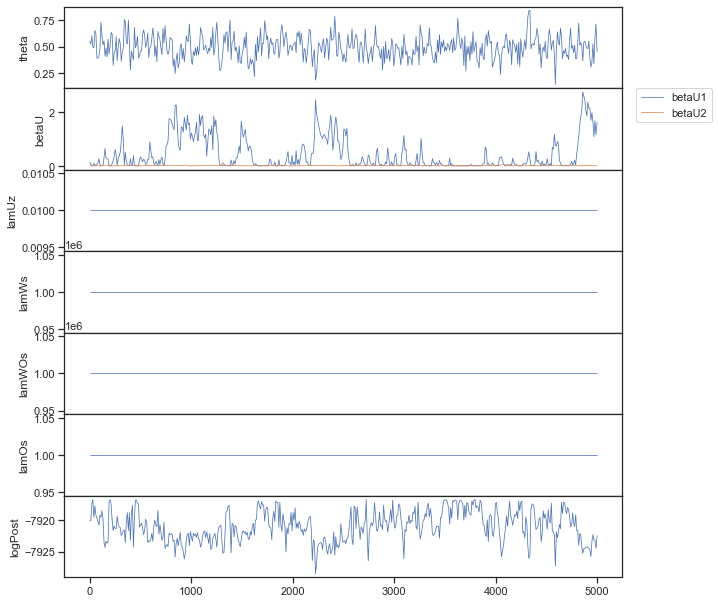

In [4]:
plot_trace(mod)

The key observation to make about the parameters is that we fixed
lamOs to 1. lamOS is a precision that divides the Sigy values. More on
that below, but by fixing this at 1, the Sigy will be used exactly.

Plot of the emulator and calibration results:

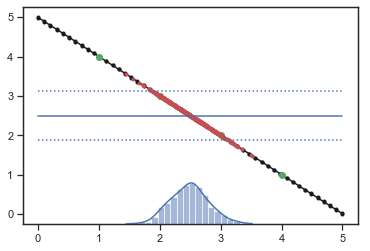

Theta std = 0.317693, var = 0.100929


In [5]:
plot_cal(mod)

The green points are 'simulations' used to build the emulator. The emulator
predictions across the domain are in black, and the uncertainty of the
emulator is plotted but not visible. There is one observation, at a value
2.5 on the y axis, projected across on the blue line. The dotted blue line
is the +/- 2sd values of the observation's uncertainty. The red points are
samples of the calibrated parameter value. This example uses a linear emulator
with a $45^\circ$ slope so the distribution of the calibrated variable should
be the same distribution as the observation. The distribution of the
posterior (calibrated) parameter samples is shown in the inset histogram.
The standard deviation and variance of these parameter samples is printed.

The variance is (approximately, to sampling uncertainty) 0.1, as expected.

Another example, using variance 0.25:

MCMC sampling: 100%|██████████| 5000/5000 [00:06<00:00, 726.97it/s]


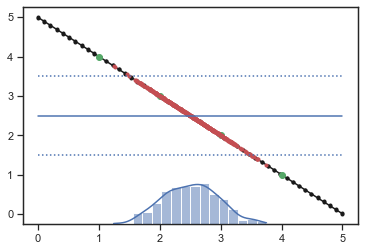

Theta std = 0.457499, var = 0.209305


In [6]:
mod=run_model(fix_lamOs=1, use_Sigy=0.25)
plot_cal(mod)

Finally, some discussion of the parameter lamOs, which is fixed at 1 in
the models above. <br>
Often in modeling the observation error is not a complete accounting of all
uncertainty, although
it is expected to be a relative value for multivariate observations. Given
the data, the observation error needs to be "inflated" to allow the data
to be consistent. And on the other hand, if the data is consistent internally
and with the model, we can be satisfied with a posterior result for parameter
calibration that corresponds to a smaller observation
variance. The precision lamOs can be fit to allow the observation
variance to be scaled given the rest of the model. This is function of the
lamOs parameter, and the default setup of a sepia model has priors on lamOs
that allow these cases. This default expects that the lamOs, and observation
error, will be adjusted given data.

In the example below, we continue with an assumption of linearity for the
emulator, but will set the observation error variance to be very large, in this
case the default variance of 1 for a error distribution N(0,1).
The lamOs parameter dividing that observation variance will be calibrated.

MCMC sampling: 100%|██████████| 5000/5000 [00:07<00:00, 656.26it/s]


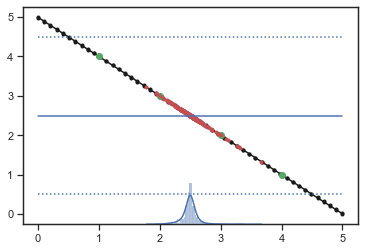

Theta std = 0.155874, var = 0.024297


In [7]:
mod=run_model()
plot_cal(mod)

The result is that Sepia's default priors cause lamOs to be large, reducing
the observation error and the corresponding posterior calibrated distribution
of the parameter. The lamOs posterior sampled is much larger than 1:

In [8]:
print('lamOs sample mean = %f'%(np.mean(mod.get_samples()['lamOs'])))

lamOs sample mean = 497.579580


## Conclusion
This example shows the use and effect of Sigy in the Sepia model, and
it's companion parameter lamOs. Depending on the use of the model some
adjustment of default parameter values might be necessary, and the analysis
above demonstrates fixing lamOs to enforce that the analysis
respect exactly the specified observation errors.

Note that the Sigy is supplied on the scale of the problem's y response,
and is scaled internally to be consistent with the internal scaling
(by default, standardization of y_sim to N(0,1)).
